The objective of the following is to obtain the blog raw text & tags associated with the blogs

In [1]:
import unicodedata
import sys


# Constants
RAW_SQL_DATA = "RAW SQL data.txt"
BLOG_TAG_FILENAME = "blog and tags.txt"
NON_ENGLISH_BLOG_TAG_FILENAME = "non-English blog and tags.txt"

# https://stackoverflow.com/questions/11066400/remove-punctuation-from-unicode-formatted-strings/11066687#11066687
PUNCTUATION_UNICODE_TABLE = dict.fromkeys(i for i in range(sys.maxunicode) if unicodedata.category(chr(i)).startswith('P'))

from nltk.corpus import stopwords
STOPWORD_LIST = stopwords.words('english') 

Library Functions

In [2]:
from bs4 import BeautifulSoup

def removeHtmlCss(html):
    """
    Description: This function cleans up an input string by removing the HTML tags from it.
    
    Source: https://stackoverflow.com/questions/22799990/beatifulsoup4-get-text-still-has-javascript
    https://stackoverflow.com/questions/6467043/extracting-element-and-insert-a-space
    ^ I had to figure that out because URLs would be meshed up with future lines.
    e.g. "found at http://www.tritonsvc.com.</p><p><strong><em>About"
    Would become "found at http://www.tritonsvc.com.About" without the (separator=u' ')
    """
    
    soup = BeautifulSoup(html, "html5lib") # create a new bs4 object from the html data loaded

    for script in soup(["script", "style"]): # remove all javascript and stylesheet code
        script.extract()
        # script.decompose()
        
    # Adds space after removing HTML/CSS tags
    # Todo: Figure out way to put words back together
    text = soup.get_text(separator=u'')

    return text

# To install langdetect: pip install langdetect
import langdetect
from langdetect import detect
from langdetect.lang_detect_exception import ErrorCode, LangDetectException

# This function takes in an input string, and checks if most of that string is in English or not
def detectLanguage(text):
    """
    Description: This function returns a list of possible languages that an input string can be
    """
    # Detect if string contains mostly non-Latin characters
    chinese_character_count = 0
    for ch in text:
        if ord(ch) > 0x4e00 and ord(ch) < 0x9fff:
            #print("Chinese: " + str(ch))
            chinese_character_count += 1

    chinese_percentage = chinese_character_count / (len(text.split()) + chinese_character_count)
    
    if chinese_percentage > 0:
        print("Chinese Percentage: " + str(chinese_percentage) + ", " + str(title))
    
    if chinese_percentage > 0 and chinese_percentage < 0.50:
        print("Warning - Unsure if Chinese! Assumming it is not Chinese!")
        #print("Chinese Percentage: " + str(chinese_percentage) + ", " + str(title))
        print(str(text))
        
    elif chinese_percentage > 0.50:
        print("Probably Chinese")
        #print("Chinese Percentage: " + str(chinese_percentage) + ", " + str(title))
        return ['zh:{}'.format(chinese_percentage)]
    
    try:
        # Check for other foreign languages
        language_dector_result = detect(text)

        possible_language_list = langdetect.detect_langs(text)
        if len(possible_language_list) >= 2:
            print(text)
            print(possible_language_list)

        # print(language_dector_results)
        # if language_dector_results != 'en':
        #    print(language_dector_results)

        return possible_language_list

    except LangDetectException:
        print("Empty Blog Entry?")
        #print("Title: {}\nBlog: {}\nTags: {}\n".format(title_line, blog_line[:100], tag_line))
        print("Text: {}".format(text))
        print("\n\n")
        return "UNKNOWN"

def _remove_all_attrs(soup):
    for tag in soup.find_all(True): 
        tag.attrs = {}
    return soup 
    
import nltk
import string
import re
from nltk.tokenize import TweetTokenizer
    
def cleanUpText(original_text):
    """
    Description: This function removes puncutation
        
    XXX: Add flags for 
        - removing numbers
        - certain types of punctuation
        - retaining lower/uper-case
    """
    
    modified_text = original_text

    # Convert text to all lower-case
    modified_text = modified_text.lower()
    
    # Remove URLs/File directories
    modified_text = re.sub(r'^https?:\/\/.*[\r\n]*', '', modified_text, flags=re.MULTILINE)

    # Remove punctuation
    modified_text = modified_text.translate(PUNCTUATION_UNICODE_TABLE)

    # Remove numbers
    modified_text = re.sub(r'\d+', '', str(modified_text))

    # Tokenize
    # tokens = no_numbers.split()
    
    # Remove code
    
    
    
    return modified_text
    
def printMostCommonWords(tokens):
    """
    Graphs the 50 most common tokens given
    """
    
    ##############
    # Graph Data #
    ##############
    import nltk
    import matplotlib.pyplot as plt

    # This is to make the graph bigger
    plt.figure(figsize=(15, 5))  # the size you want

    # Remove stopwords according to NLTK
    filtered_words = [w for w in tokens if not w in STOPWORD_LIST]

    fdist2 = nltk.FreqDist(filtered_words)
    fdist2.plot(50, cumulative=False)
    
    print(fdist2.most_common(50))

In [3]:
import datetime
import mysql.connector
from mysql.connector import errorcode
import xml.etree.ElementTree as ET

cnx = mysql.connector.connect(user='root', password='liferay',
                              host='127.0.0.1',
                              database='sample_customer_data')
cnx.close()

try:
    cnx = mysql.connector.connect(user='root', password='liferay',
                              host='127.0.0.1',
                              database='sample_developer_data',
                              charset='utf8')

    cursor = cnx.cursor(buffered=True)
    cursor2 = cnx.cursor()

    query = ("SELECT blogsentry.title, blogsentry.content, assetentry.entryId FROM sample_developer_data.assetentry \
                INNER JOIN sample_developer_data.blogsentry \
                ON sample_developer_data.assetentry.classPK = sample_developer_data.blogsentry.entryId;")
    cursor.execute(query)
    
    counter = 0

    #print(cursor)
    
    counter_with_content = 0
    
    file = open(BLOG_TAG_FILENAME, "w", encoding='utf8')
    non_english_file = open(NON_ENGLISH_BLOG_TAG_FILENAME, "w", encoding='utf8')

    for (title, content, entryId) in cursor:
        
        # Cleanup Text
        clean_title = removeHtmlCss(title)
        clean_title = clean_title.replace("]]>", "")
        clean_content = removeHtmlCss(content)
        clean_content = clean_content.replace("]]>", "")
        #clean_content = content
        
        # Run the HTML CSS cleanup again, because of nested HTML/CSS/JS code
        #clean_content = removeHtmlCss(clean_content)

        #print(notags)
        
        
        # Reduce all whitespace to a single space
        clean_title = " ".join(clean_title.split()).strip()
        clean_content = " ".join(clean_content.split()).strip()
                
        query2 = ("SELECT assettag.name FROM sample_developer_data.assettag \
                      WHERE sample_developer_data.assettag.tagId \
                      IN (SELECT assetentries_assettags.tagId \
                        FROM sample_developer_data.assetentries_assettags \
                        WHERE sample_developer_data.assetentries_assettags.entryId = " + str(entryId) + ")")

        cursor2.execute(query2)
        tag_list = list()
        
        for (name) in cursor2:
            tag_list.append(name[0])
        
        # Verify that tags exist & there's content
        if tag_list and clean_content:
            
            # Verify content is in English
            content_language = detectLanguage(clean_content)
            
            print(content_language)
            
            lang = str(content_language[0]).split(':')
            
            # if ('en' in content_language) and (content_language.count(':') <= 1):
            if ((lang[0] == 'en') and (float(lang[1]) > .80)):
                counter_with_content += 1

                print("\n{}) {}\n{}\n{}\n\n".format(counter, clean_title, clean_content[:50], tag_list))

                output = "{}\n{}\n{}\n\n".format(title, clean_content, ",".join(tag_list))
                output.encode('utf8')
                # print(output)
                file.write(output)
            else:
                output = "{}\n{}\n{}\n{}\n\n".format(title, clean_content, ",".join(tag_list), content_language)
                output.encode('utf8')
                non_english_file.write(output)
                continue
                
        else:
            #print("{}) Empty String".format(counter))
            #output = "{}\n{}\n{}\n\n".format(title, clean_content, ",".join(tag_list))
            pass
            
        
        #print(content[0].strip())
        counter += 1
        
        if counter % 500 == 0:
            print("Current Count: " + str(counter))
            pass

    file.close()
    non_english_file.close()
    print("Total Entries: {}\nContent Entries: {}".format(counter, counter_with_content))

except mysql.connector.Error as err:
  if err.errno == errorcode.ER_ACCESS_DENIED_ERROR:
    print("Something is wrong with your user name or password")
  elif err.errno == errorcode.ER_BAD_DB_ERROR:
    print("Database does not exist")
  else:
    print(err)
else:
  cnx.close()



[en:0.9999960104327587]

0) Liferay-ICEsoft Technology Partnership
On 7/23/2007, Liferay and ICEsoft announced a tech
['icefaces', 'liferay', '4.3', 'icesoft']


[en:0.9999972117074983]

3) Built Backwards?
I've noticed in alot of our projects, we've been r
['liferay', 'bloated', 'literay', 'plugin system', 'features']


[en:0.9999979027377315]

4) Web2ForDev Conference
I'm currently at the Web2ForDev conference in Rome
['fao', 'ifad', 'web2.0', 'conference', 'development']


[en:0.9999978112058409]

5) Lotus vs. Excel
A recent blog made a comparison between Lotus 123 
['liferay', 'bloated', 'features', 'javascript', 'excel', 'lotus']


[en:0.9999974622277414]

6) Embarrassment Spawns a New Blog
Here I am in Dalian, China, an area which I hardly
['china', 'chinese culture', 'dalian', 'embarrassing moment']


[en:0.9999952732613853]

9) Fav Podcasts / Germany / Facebook
I'm listening to and watching a lot of podcasts la
['facebook', 'geekbrief', 'germany', 'podcasts']


[en:0.9999983216

[en:0.9999963286161728]

107) Liferay Plugin Development Guide
Quietly and without much fanfare, we have released
['liferay', 'docs']


[en:0.9999969598131466]

110) Liferay on Native JBoss-Tomcat
A few weeks ago I blogged about Tomcat's JNI nativ
['tomcat', 'performance', 'jboss']


[en:0.9999950923258281]

114) MySpace by Liferay
From the makers of the world's leading enterprise 
['myspace alerts login liferay']


[en:0.9999958559952467]

116) WebDAV Class 1 Compliance
After several months in the working, we finally go
['integration', 'webdav']


[en:0.9999978520996645]

118) PHP Portlet
While I was surfing the Wiki I found a distress si
['portlet', 'php', 'snowboard', 'test']


[en:0.9999982472630722]

119) Wiki overhaul ... continues
Happy new year everybody!!It's been a while since 
['wiki', 'jspwiki']


[en:0.9999960792588752]

120) Documentation Milestone Reached
First of all, a belated Happy New Year! This is my
['liferay', 'docs']


[en:0.9999971712276138]

121) My Liferay
My 

[en:0.999996128980983]

234) Integrating OpenSSO with Liferay 5.1 on Glassfish
OpenSSO is an open source project for single sign 
['liferay  opensso  glassfish']


[en:0.9999960781802449]

236) A Truly Social Enterprise
Brian just wrote a great blog about the Meetup and
['liferay', 'collaboration', 'meetup', 'social']


[en:0.9999967146984438]

239) Solr integration
We've made some enhancements to the search infrast
['search engine', 'solr', '5.1.1']


[en:0.9999953913390704]

240) Court Rules in Favor of Open-Source Movement [Sharing]
The open-source software movement (also known as t
['open source']


[en:0.9999967933993575]

241) Sharing Data Between Portlets
If you want to share data between portlets, a comm
['session', 'sessions', 'inter portlet communication', 'ipc', 'shared data']


[en:0.9999990779147991]

242) Switched from Windows to Mac
Perhaps I'm dating myself, but when I entered coll
['mac', 'mac os x']


[en:0.9999971748018184]

243) Filthy Rich Portlets with ICEfaces at

[en:0.9999963214355885]

335) PRESS RELEASE: Liferay wins EContent 100 Award!
Liferay Breaks Into EContent Magazine's ''EContent
['award', 'press release']


[en:0.9999966113626997]

336) PRESS RELEASE: Employers Direct Insurance Company Implements Liferay
Employers Direct Insurance Company CreatesHigher C
['press release']


[en:0.9999961219709372]

337) PRESS RELEASE: Liferay Teams With Pramati To Multiply Product Capability and Value
Liferay Teams With Pramati To Multiply Product Cap
['press release']


[en:0.9999966060321148]

355) PRESS RELEASE: Liferay Portal 4.0.0 is released!
New Liferay Portal 4.0 ExtendsGreater Control To A
['product release', 'press release']


[en:0.9999946590423507]

359) PRESS RELEASE: Liferay Teams With Alfresco And Virtuas
Liferay Teams With Alfresco And Virtuas To Provide
['press release']


[en:0.9999961428793659]

373) PRESS RELEASE: Liferay Leads Market as Visionary in Gartner’s Magic Quadrant
Liferay Leads Market as Visionary in Gartner’s Mag
['lif

[en:0.999995633815937]

425) Performance testing using a nifty portal tool
We all want to optimize the processing time of our
['performance', 'testing', 'servlet filter', 'tunning']


[en:0.9999970819926799]

426) Creating custom login front end
Update: Fri 12 Feb 2010, I should have made it mor
['login', 'spring', 'interface util implementation']


[en:0.9999974880719339]

427) PRESS RELEASE: Liferay Portal 5.2 Released
Liferay Portal 5.2 Released Integrated Portal, Con
['5.2', '3 level', 'release']


[en:0.9999962935384961]

428) Liferay Portal v5.2 is out, why is everybody so excited?
The new release of Liferay Portal is out and I thi
['release', 'liferay v5.2']


[en:0.9999960123378819]

429) PRESS RELEASE: Liferay Proposes Value-Driven Solutions at Forrester Enterprise Architecture Forum
Liferay Proposes Value-Driven Solutions at Forrest
['liferay portal', 'soa', 'conference', 'analyst', 'forrester', 'enterprise architecture']


[en:0.9999969348249554]

430) Web Content enhancemen

[en:0.9999983759063455]

508) Liferay Seminar: Making Open Source Work For You in These Tough Economic Times
CIGNEX and APAR would like to invite you for a sem
['news', 'events', 'conference']


[en:0.9999955910714767]

511) Full Integration of Liferay 5.3, Alfresco 3.1 E, LDAP, SSO, and OpenX 2.6
The upgrade of the solution - Full Integration of 
['liferay', 'alfresco', 'openx', 'ldap', 'sso', '5.2', '5.1', '6.0']


[en:0.9999951230939843]

519) Using the JSON service APIs to reduce the need for page refreshes
We've been working in the last few days with our p
['service builder', 'web services']


[en:0.9999961199076014]

525) Tweetray
Hi Everyone,Just wanted to let you all know about 
['tweetray']


[en:0.9999967337319168]

530) PRESS RELEASE: Liferay Spain Sees Rapid Growth and Expands European Ecosystem
Liferay Symposiums Bring Open Source and Business 
['event', 'meetup', 'conference', 'enterprise edition', 'europe', 'speaker']


[en:0.999997472961389]

533) Interview: Is Social M

[en:0.9999966230700823]

637) String Performance
String in Java is special, because its immutable p
['performance', 'string', 'stringbundler', 'garbage', 'gc']


[en:0.9999965768495322]

638) IO performance
IO is very important in almost all types of applic
['performance', 'io', 'synchronization']


[en:0.9999967421280711]

639) Love, Marriage, and Liferay?
It's been awhile since I last posted a blog. It's 
['liferay']


[en:0.9999951454607734]

642) Sharing Content - Knowledge base - across Organizations and Communities
The topic “sharing content across organizations” h
['5.2', 'permission', 'knowledge base', 'sharing', 'membership', 'hierarchy', 'ownership', '6.0']


[en:0.9999974092123903]

643) Integrating Alfresco through CMIS in Liferay
In brief, you could integrate Alfresco in the port
['liferay', 'alfresco', 'cmis', 'hook', '6.0']


[en:0.9999974709240864]

645) PRESS RELEASE: Liferay Reports Strong Company Growth and Leadership in 2009
Liferay Reports Strong Company Growth and

[es:0.8571387182478705, en:0.14285886626093797]
[en:0.9999979681912632]

711) Import and export Knowledge based articles
What’s knowledge base or knowledge management (KM)
['5.2', 'knowledge base', '6.0', 'taxonomies', 'multiple languages', 'docbook', 'export', 'import', 'xml']


[en:0.9999958056590704]

712) Visiting Barcelona
Tomorrow, Thursday March 18th, I'll be visiting Ba
['event']


[en:0.999996772016682]

722) Open Source: The Future or a Trend?
Is Open Source a Growing Market or a Temporary Tre
['liferay', 'costs', 'trends', 'open source']


[en:0.9999982699608183]

724) Liferay Featured @ HTML5 Gallery
Good news, everyone; Liferay.com has been featured
['liferay', 'elements', 'gallery', 'html5']


[en:0.9999962620114762]

729) PRESS RELEASE: Allianz Australia Leverages Liferay Portal for Core Online Marketing Strategies
Allianz Australia Leverages Liferay Portal for Cor
['liferay portal', 'story', 'web publishing', 'customer', 'insurance']


[en:0.9999966165542411]

730) PRES

[en:0.9999969536676834]

755) Liferay 6 and Semantic Web
The Semantic Web is an evolving development of the
['liferay', 'folksonomies', 'taxonomies', '6', 'ontolog', 'semantic web', 'web 3.0']


[en:0.9999976519608418]

757) SLA Tool
Service Level Agreement Tool1 adds the following i
['sla tool']


[en:0.9999966994368819]

758) Liferay IDE 1.0 Preview
Hello everyone, **Update: fixed video links, also 
['ide']


[en:0.9999987654616339]

768) Debuging Ant classpath issues
When working with Liferay, sometimes you might enc
['debug', 'ant', 'build', 'classpath']


[en:0.9999982730857416]

769) Alfresco 3.3 delivers CMIS support, integration with Liferay 6
Alfresco 3.3 with implementation of CMIS provides 
['cmis', 'alfresco 3.3', 'liferay 6']


[en:0.9999980209008905]

773) PRESS RELEASE: Design with Liferay, Portal Leader launches new program to help users approaching EOL worldwide.
Design with Liferay Portal Leader launches new pro
['liferay portal', 'events', 'open source', 'alloy ui', 


[en:0.9999962638610638]

840) Adding Custom Attributes capabilities on custom assets in Liferay 6 through plugins
The portal provides a framework to add custom attr
['knowledge base', 'liferay 6', 'plugins', 'custom asset', 'custom attributes']


[en:0.9999960967003656]

841) Liferay Roadshows Coming To A City Near You
Over the next couple of weeks, Liferay and our par
['liferay', 'partners', 'roadshows']


[en:0.9999971174900388]

842) Liferay IDE 1.1 Released
The latest version of Liferay IDE version 1.1 has 
['development', 'ide', 'eclipse', 'liferayide']


[en:0.9999978984125427]

843) Tricks of Velocity class loading
Recently I was asked to solve a WCM dynamic Templa
['journal', 'template', 'velocity', 'classloader', 'wcm', 'web content']


[en:0.9999986549080231]

844) Listing Article fragments dynamically using Liferay's WCM Templates
So my last blog post involved a classloader trick 
['journal', 'template', 'velocity', 'wcm', 'web content', 'xml']


[en:0.9999974680400198]

84

[en:0.9999985010512531]

903) Embedding a portlet in web content
Many people have asked, "How can I embed a portlet
['embed', 'portlet', 'web content']


[en:0.9999948694254792]

906) Community Roundup
Finally returned from Liferay's annual employee re
['staging', 'comic shirts', 'french community', 'utf 8', 'lakers', 'holiday season']


[en:0.9999971569036277]

907) Speeding up LDAP import process and Liferay authentication
Liferay 5.2 EE and 6 improved the capabilities of 
['ldap', 'import', 'liferay 6', 'liferay 5.2', 'performance', 'authentication', 'base dn']


[en:0.9999984084119957]

909) The Oaks Camps and Conference Center
I spent Dec 16th - Dec 20th at THE OAKS Camp and C
['world impact', 'angeles national forest', 'liferay', 'los angles', 'churches']


[en:0.9999970105547452]

910) Community Roundup: Holiday Edition
Happy Holidays from Liferay and our community! Hop
['open source cms', 'roadshow', 'french community', 'community developers', 'community rank', 'sso', 'portuges

[en:0.9999982962097946]

978) Community Roundup
Miss me yet? It's been a busy several weeks here a
['community', 'ecs', '100 papercuts', 'liferay 6', 'features', 'east coast symposium', 'alfresco', 'hungary', 'integration', 'social', 'team']


[en:0.9999962951909792]

979) Social Visualization and Analytics with Liferay
Recently I did a Liferay LIVE presentation on driv
['community', 'liferay ide', 'social', 'equity', 'portlet', 'social equity', 'tag', 'tag cloud', 'tags', 'trending', 'value']


[en:0.9999955255905799]

981) PRESS RELEASE: Liferay To Ship MuleSoft Tcat Server Bundle
Liferay To Ship MuleSoft Tcat Server Bundle New Of
['tomcat', 'mulesoft']


[en:0.9999966589195646]

982) Will my hashing cache keys get a conflict?
The short answer to the title question is YES. How
['performance', 'cache']


[en:0.9999975077651597]

983) Liferay on Amazon Elastic Beanstalk and EC2
Recently I came across a forum post asking about d
['ssh', 'tomcat', 'amazon', 'rds', 'elastic beanstalk', 'c

[en:0.999997168066654]

1002) Liferay Hungary Symposium Pics and Videos
After months of preparation, careful planning, Lif
['symposium', 'pictures', 'events', 'liferay hungary', 'central europe']


[en:0.9999953823846417]

1003) Mexico Church Build
On June 3rd - 5th I went with Rock Harbor Church t
['mexico', 'missions trip']


[en:0.9999979422116436]

1005) Yet Another Liferay JSON Service Example
The past couple of years I've seen many examples o
['json', 'rest', 'services', 'apache commons', 'http', 'tunnel-web', 'journal']


[en:0.9999985650855414]

1007) Community Roundup
8 Days to the official start of summer in the nort
['community', '100 papercuts', 'mobile', 'amazon', 'ec2', 'bugsquad', 'json', 'france symposium', 'hungary symposium', 'translations', 'user groups', 'scorm', 'lms', 'liferay live', 'accessibility', 'a11y', 'drupal']


[en:0.9999971931965419]

1009) Liferay Accessible Websites
Many people ask us frequently, is liferay accessib
['accessibility', 'wcag2.0', 'wcag1.

[en:0.9999971026352505]

1086) Radio Liferay Episode 5: Cynthia Wilburn
Episode 5 of Radio Liferay is out. I'm speaking wi
['radio liferay']


[en:0.9999976429231724]

1087) Random Liferay Code Snippets
I've taken to using github.com's gist service quit
['liferay', 'theme', 'git', 'snippet', 'code', 'examples', 'gist']


[en:0.9999956631318199]

1088) Liferay at the Gartner Symposium ITXPO
I'm excited to announce that Liferay has been invi
['gartner', 'conference presentation']


[en:0.9999968147300666]

1094) Embedding portlets in themes on Liferay
Liferay has long had the ability to embed portlets
['portlet', 'velocity', 'theme', 'freemarker', 'embedded', 'embed']


[en:0.9999983702313779]

1095) Radio Liferay Episode 6: Aaron Delani
Episode 6 of Radio Liferay is out. I'm speaking wi
['radio liferay']


[en:0.99999406023553]

1096) Radio Liferay Episode 7: Julio Camarero
Liferay for your ears: Episode 7 of Radio Liferay 
['radio liferay']


[en:0.9999955393721315]

1097) How to monit

Warning - Unsure if Chinese! Assumming it is not Chinese!
[Czech] [Deutsch] [English] [Español] [Portuguese] [中国的] Liferay tim sa zadovoljstvom objavljuje izlazak Liferay Portal 6.1 EE! Liferay Portal 6.1 EE tvrtkama pruža jedinstvenu web platformu za socijalnu suradnju, upravljanje web sadržajem te razvojne alate za izradu prilagođenih rješenja. Pogledajmo neke od važnijih novosti i promjena u ovoj verziji: Liferay Sync za dijeljenje dokumenata - Liferay Sync će vas razriješiti brige vezane za pristup datotekama tako što ih čini dostupnim u svakom trenutku gdje god je to potrebno. Uz Liferay Sync, dokumenti pohranjeni u biblijoteci dokumenata su automatski sinkronizirani sa svojim inačicama u vašem mobilnom, stolnom i tablet uređaju. Broj sinkroniziranih dijeljenih dokumenata nije limitiran a sinkronizacija se obavalja sa vašom vlastitom Liferay implementacijom stoga ne morate brinuti o sigurnosnim problemima koji dolaze s javno dostupnim cloud rješenjima. Potpuno redizajnirana i obno

[es:0.999996306222436]
[en:0.9999949197364866]

1291) Device detection in Liferay
I have started playing with device detection when 
['iphone', 'mobile', 'device', 'detection', 'capabilities', 'android', 'screen']


[en:0.9999959724612111]

1294) Creating a plugin to extend other plugin
Did you know it is possible to create a plugin to 
['development', 'plugins', 'extensions', 'overwrite']


[en:0.9999949227460381]

1306) OpenSocial Gadgets chapter released in Development Guide
It's finally here! OpenSocial gadgets is the next 
['opensocial gadgets']


[en:0.9999963417152643]

1307) Docs Weekly: A New Series
Since we haven't been announcing it much, you're p
['documentation', 'docs']


[en:0.9999963764226983]

1310) Liferay North American Symposium 2012 - Another whirlwind succes
I'm almost back home from San Francisco after yest
['lrnas2012']


[en:0.9999967819782432]

1311) Homework Club at World Impact's Elementary School
I have had the privilege of also using my EVP hour
['world im

[en:0.9999990779321921]

1365) Radio Liferay Episode 24: Zsolt Balogh, LESA
This is another episode recorded at the European S
['radio liferay']


[en:0.9999971614340073]

1366) Liferay's Architecture: Caching (Part 1)
Here I am again with another in the series about L
['liferay', 'architecture', 'performance', 'caching']


[en:0.9999955644211276]

1367) The power (user) is back
The title will probably make some people argue tha
['permissions', 'roles']




C:\ProgramData\Anaconda3\lib\site-packages\bs4\__init__.py:219: UserWarning: "b'.'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)


[en:0.9999979888006353]

1378) Maven chapter (new) for Liferay 6.1 Development Guide
If you have been curious about Maven, or if you wo
['maven']


[en:0.9999960704281075]

1381) AlloyUI Wallpaper
Hi everyone! As you know, recently launched Alloy 
['alloyui', 'wallpaper', 'design']


[en:0.9999988264546008]

1384) Tree Trimming: Volunteering for the less technical, less musical, yet willing employee
Several months ago I had asked Stephanie May if th
['world impact', 'evp', 'volunteering', 'tree trimming']


[en:0.9999967553961037]

1388) Making a remote javascript library loaded dynamically by AUI and be an AUI plugin
In the real world project, there are times when a 
['aui', 'remote library', 'get', 'global portlet', 'codevelop', 'aui2.0']


[en:0.9999962683796788]

1391) AlloyUI and the importance of CDN
Some weeks ago we announced the preview release of
['alloy', 'alloyui', 'performance', 'cdn']


[en:0.9999968243710238]

1396) User Experience (UX), descriptions and relationships (1

[en:0.9999987973754898]

1489) Is free of charge worth it?
Twenty years ago, June 1993, Adobe introduced its 
['portable document format', 'creating value', 'pdf', 'acrobat']


[en:0.9999979803191797]

1491) Open Data, a New Opportunity for the 'information' Industry?
This is an adaptation of a blog I wrote for Wolter
['open data', 'publishers']


[en:0.9999974682742776]

1492) Monitoring JMX through http
Monitoring JMX data has been always a painful proc
['osgi', 'jmx', 'monitoring']


[en:0.9999971176689354]

1493) Radio Liferay Episode 29: Milen Dyankov
Please welcome yet another return guest, Milen Dya
['radio liferay']


[en:0.9999982889224007]

1498) Continuous Integration Best practices: #4 Never go home on a broken build
I love that picture! Imagine yourself any Friday, 
['testing', 'build engineer', 'revert', 'distributed teams', 'follow the sun']


Current Count: 1500
[en:0.9999971450096716]

1500) kaleo configuration for custom portlet in liferay 6.0 EE.
Step1 : Add followin

[en:0.9999970036858788]

1648) Radio Liferay Episode 37: Iliyan Peychev on Frontend and AlloyUI
I talked with Iliyan Peychev, Software Developer f
['radio liferay']


[en:0.9999979555143413]

1649) Dynamic Data Auto Update in Liferay Plugin Portlet
Objective: Update the content in portlet for parti
['ajax complete', 'ajax json', 'aui ajax', 'aui json', 'auto refresh', 'jquery', 'jquery ajax', 'json data', 'json response', 'liferay ajax', 'liferay aui', 'liferay jquery', 'liferay json', 'set interval']


[en:0.9999958882856151]

1661) Liferay Service Builder Many to Many Relation in Plugin Portlet
Objective: Implement Many to Many Relation in life
['liferay many to many', 'liferay one to many', 'liferay service builder', 'liferay services', 'mapping-key', 'mapping-table', 'service builder many to many', 'service builder relations', 'service layer']


[en:0.9999957707443714]

1662) Introduction to Liferay Portal
Introduction to Liferay Portal Liferay is Portlet 
['alfresco', 'document ma

[en:0.999996230169572]

1836) Making Liferay Portal 6.2 RTL friendly - The Right to Left plugin
Middle Eastern languages, such as Hebrew and Arabi
['rtl']


[en:0.9999961683852352]

1841) Liferay Service Builder Custom Service Methods
Introduction: Liferay Service Builder is a tool to
['liferay custom service methods', 'sb custom methods', 'principle exception', 'liferay principle exception', 'liferay hibernate session bound exception', 'session bound exception']


[en:0.999995795333118]

1848) Add Responsive Layouts to Liferay 6.1
One issue has come up time and time again with 6.1
['layouts', 'responsive', 'css', 'marketplace', 'woodbenchmedia', '6.1']


[en:0.9999974807629789]

1854) "The plugin worked on my computer" is not valid anymore
Hello my lovely Liferay developers! I'm very proud
['integration testing', 'arquillian', 'plugins', 'quality', 'osgi']


[en:0.9999971490686542]

1855) Upcoming customization options with Application Display Templates
Application Display Templates h

[en:0.9999943449409292]

2006) Liferay vs Sharepoint
In the ever changing world of enterprise IT, our c
['sharepoint', 'microsoft']


[en:0.9999951250652988]

2008) Securing Liferay Chapter 2: Liferay's configuration
You probably know the basic installation instructi
['security']


[en:0.9999993467135305]

2010) An experience in EVP: a little insight on learning
Then it happened again. I felt like a few times a 
['evp', 'education', 'volunteering']


[en:0.999995606459499]

2012) Liferay 7 Milestone 2 - The adventure continues
It's been around 2 months since Milestone 1 and we
['milestones', 'alloy editor', 'liferay 7']


[en:0.9999950484922752]

2018) Securing Liferay Chapter 3: Port issues and HTTP/HTTPS
You probably know the basic installation instructi
['security']


[en:0.9999979575831195]

2019) Securing Liferay Chapter 4: More lockdown
You probably know the basic installation instructi
['security']


[en:0.999997296484004]

2020) Liferay 6.2 Certified Professional Developer Now 

[en:0.9999975038724395]

2209) Portlets Inside Portlets
Portlets are components which create a portal appl
['portlet', 'embed', 'embedding', 'runtime']


[en:0.9999977964779161]

2220) Vaadin Pro Tools and Liferay
So Vaadin has a complete set of basic widgets (che
['vaadin control panel', 'vaadin 7', 'vaadin pro tools', 'vaadin charts']


[en:0.999996226863689]

2221) 8 Ways To Get Involved With The Liferay Community
Over the years, Liferay has been able to provide m
['community', 'dev.liferay']


[en:0.9999968584182328]

2222) New Liferay Faces Release - Alloy Input Components
New Liferay Faces Release - Alloy Input Components
['6.2', 'jsf', 'alloyui', 'liferay-faces-alloy']


[en:0.9999979983078829]

2224) Liferay Inter Portlet Communication (IPC)
Liferay Inter Portlet Communication (IPC) is mecha
['client side ipc', 'event listener', 'event producer', 'ipc ajax', 'ipc cookies', 'ipc events', 'ipc page level', 'ipc portal level', 'ipc portlets session', 'ipc public render parameters'

[en:0.9999964269094768]

2348) Setting up Valamis from GitHub
Valamis is a powerful open source learning solutio
['valamis']


[en:0.9999968778280522]

2353) Reach the Right Audience: Integrating Audience Targeting with your Apps
Liferay Developer Conference (aka DEVCON) is a gre
['audience targeting', 'integrability']


[en:0.9999959364627025]

2355) One step further for Liferay Screens: offline support is here
Hey folks! The new version of Liferay Screens, ver
['mobile screens', 'mobile', 'screens', 'liferay screens', 'android', 'ios']


[en:0.9999956537799685]

2356) Carousel with Structure and Temple in WCD
Struture <root available-locales="en_US" default-l
['carousel', 'wcm']


[en:0.9999972327879723]

2358) Powerful grid component for RESTful data sources
In web applications we often need to deal with lar
['rest', 'liferay spring', 'dynamic data list', 'vaadin', 'spring mvc', 'spring data', 'polymer']


[en:0.9999967945896139]

2361) Importing a Virtual Machine with Liferay to th

Current Count: 2500
[en:0.9999981090239013]

2510) Content-driven applications: A Marriage Between CMS Templates and RESTful services
I've been busy building web application content. A
['cms structure', 'cms template', 'rest']


[hu:0.9999968410507483]
[en:0.9999975473623515]

2516) Liferay 7 GA1 Doxygen
Doxygen Output for Liferay 7 CE GA1 Visualize Life
['doxygen']


[en:0.9999989483399919]

2520) Radio Liferay Episode 57: Jim Hinkey and Cody Hoag on documentation
Today I'm welcoming a repeat guest and a new one: 
['radio liferay']


[en:0.9999973274976874]

2521) Creating service builder mvc portlet in Liferay 7 with Liferay IDE 3.
Liferay IDE Download Page: https://web.liferay.com
['ide', 'osgi', 'module', 'liferay7', 'blade', 'service builder', 'mvc portlet']


[en:0.999996681100747]

2523) How can I build Liferay 7.0 from source?
How can I build Liferay 7.0 from source? To build 
['liferay', 'liferay-7.0', 'build', 'liferay-7']


Chinese Percentage: 0.8861283643892339, 使用Liferay I

[en:0.9999960260770385]

2684) Fantastic Extension Points - And Where to Find Them
One more year, it's been great to meet many of you
['migration', 'upgrading', 'extensibility', 'hooks']


[en:0.9999966104450281]

2685) Liferay Jenkins
Hi, today i have done integration of jenkins using
['jenkins']


[en:0.9999965052486568]

2688) Stopping By Abou Shousha's On A Snowy Evening
(or) Why categories are so much more than nestable
['content', 'categories', 'meta-tags', 'property']


[en:0.999995456643063]

2697) Migrate / Upgrade to LR 6.2 CE GA6 from LR 6.2 old CE releases
Dear Liferay Folks , This blog is specially for th
['migration', 'upgradation', 'upgrade', 'liferay 6.2 ce ga1', 'liferay 6.2 ce ga6', 'liferay', 'community edition', 'ce', 'version migration', 'version upgradation', 'version upgrade', 'liferay known issues', '6.2 known issues', 'liferay upgrade vishal panchal', 'liferay vishal', 'vishal panchal']


Chinese Percentage: 0.9179875947622329, 译文：OSGi Module依赖
Probably Chinese

C:\ProgramData\Anaconda3\lib\site-packages\bs4\__init__.py:282: UserWarning: "https://github.com/OWASP/java-html-sanitizer/issues/110" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup


[es:0.9999983500784595]
[es:0.9999958835072098]
[es:0.9999952686569689]
[es:0.9999973818538185]
[es:0.9999958806549177]
[es:0.9999969798115877]
[es:0.999996160462342]
[es:0.9999977618356806]
[es:0.999995429459983]
[es:0.9999951479584334]
[en:0.9999961688913122]

2865) Tutorial of Using Promise Object in SOY Portlet to Access Liferay's web service.
In this tutorial, I am going to talk about how to 
['service builder', 'liferay dxp', 'chartjs', 'soy portlet', 'web service', 'es6', 'promise', 'banking', 'npm', 'nodejs', 'jquery']


[es:0.9999975147075847]
[en:0.9999964207376844]

2871) ServiceBuilder and Upgrade Processes
Introduction Today I ran into someone having issue
['servicebuilder', 'upgradeprocess', 'liferay-require-schemaversion']


[en:0.9999958891336188]

2872) Forms in DXP
As we all know, Liferay 7 (DXP) come with new feat
['forms', 'multistep', 'dxp forms']


[es:0.9999957741218308]
[es:0.9999946932298913]
[es:0.9999967072064249]
[en:0.9999964376081725]

2899) A Checkbox Nam

This section will open the blog & tags file, and cleanup whitespace.

In [4]:
#from langdetect import detect_langs
import langdetect
from langdetect import detect
from langdetect.lang_detect_exception import ErrorCode, LangDetectException

title_list = list()
blog_list = list()
tag_list = list()

blog_tag_file = open(BLOG_TAG_FILENAME, 'r', encoding='utf-8')
    
while True:
    title_line = blog_tag_file.readline().strip()
    blog_line = blog_tag_file.readline().strip()
    tag_line = blog_tag_file.readline().strip()
    
    try:
        #langauge = langdetect.detect_langs(blog_line)
        language = detect(blog_line)
    except LangDetectException:
        print("Empty Blog Entry?")
        print("Title: {}\nBlog: {}\nTags: {}\n".format(title_line, blog_line[:100], tag_line))
        print("\n\n")
    
    blog_tag_file.readline() # This is just to burn the extra new line
    #print("Title: {}\nBlog: {}\nTags: {}\n".format(title_line, blog_line[:100], tag_line))
    #print("Title: {} - {} {}\n".format(title_line, blog_line[100:], langauge))
    
    # We only care about entries that have blog entries
    if tag_line:
        title_list.append(title_line)
        blog_list.append(blog_line)
        tag_list.append(tag_line)
    else:
        print("End of File")
        print("Title: {}\nBlog: {}\nTags: {}\n".format(title_line, blog_line[:100], tag_line))
        break # EOF

print(blog_list[0][:100])
print(blog_list[len(title_list) - 1][:100])
print(len(title_list) - 1)

Empty Blog Entry?
Title: 
Blog: 
Tags: 




End of File
Title: 
Blog: 
Tags: 

On 7/23/2007, Liferay and ICEsoft announced a technology partnership aimed at making the ICEfaces co
Introduction: Amazon Lightsail is the easiest way to get started with AWS for developers who just ne
969


In [5]:
# Write back to file with:
# - HTML removed
# - Remove URLs (http, https, ftp, svn)

import re

# Note: This is a very naive implementation, there is probably a better way to do this.
# This regex is to remove any URLs
regex = re.compile(r"(http|ftp|https|svn):\/\/[\S]+", re.IGNORECASE)

file1 = open('CLEANUP 1 - Remove HTML and CSS.txt', "w", encoding='utf8')
file2 = open('CLEANUP 2 - Remove URLs.txt', "w", encoding='utf8')
file3 = open('CLEANUP 3 - Remove Puncuation.txt', "w", encoding='utf8')
file4 = open('CLEANUP 4 - Remove Numbers.txt', "w", encoding='utf8')
file5 = open('CLEANUP 5 - Convert to Lower Case.txt', "w", encoding='utf8')
file6 = open('CLEANUP 6 - Adjust Whitespace.txt', "w", encoding='utf8')

for index in range(len(title_list)):
    title = title_list[index]
    blog = blog_list[index]
    tags = tag_list[index]
    
    # Cleanup blog contents

    # Remove HTML, CSS, & JS
    clean_blog = removeHtmlCss(blog)
    output_string = "{}\n{}\n{}\n\n".format(title, clean_blog, tags)
    file1.write(output_string)
    
    # Remove URLs
    clean_blog = regex.sub("", clean_blog)
    output_string = "{}\n{}\n{}\n\n".format(title, clean_blog, tags)
    file2.write(output_string)
    
    # Remove punctuation
    clean_blog = clean_blog.translate(PUNCTUATION_UNICODE_TABLE)
    output_string = "{}\n{}\n{}\n\n".format(title, clean_blog, tags)
    file3.write(output_string)
    
    # Remove numbers
    #clean_blog = re.sub(r'\d+', '', str(clean_blog))
    #output_string = "{}\n{}\n{}\n\n".format(title, clean_blog, tags)
    #file4.write(output_string)
    
    # Convert to lowercase
    clean_blog = clean_blog.lower()
    output_string = "{}\n{}\n{}\n\n".format(title, clean_blog, tags)
    file5.write(output_string)
    
    # Adjust whitespace to only single spaces
    clean_blog = " ".join(clean_blog.split()).strip()
    output_string = "{}\n{}\n{}\n\n".format(title, clean_blog, tags)
    file6.write(output_string)
    
    # output_string = "{}\n{}\n{}\n\n".format(title, clean_blog, tags)
    
    #file.write(output_string)
    
    # Update array contents
    #title_list[index] = 
    blog_list[index] = clean_blog
    #tag_list[index]

#file.close()

print(blog_list[0][:100])
print(blog_list[len(title_list) - 1][:100])
print(len(title_list) - 1)

file1.close()
file2.close()
file3.close()
file4.close()
file5.close()
file6.close()

on 7232007 liferay and icesoft announced a technology partnership aimed at making the icefaces compo
introduction amazon lightsail is the easiest way to get started with aws for developers who just nee
969


Print most common words in all the blogs

End of File
Title: 
Blog: 
Tags: 



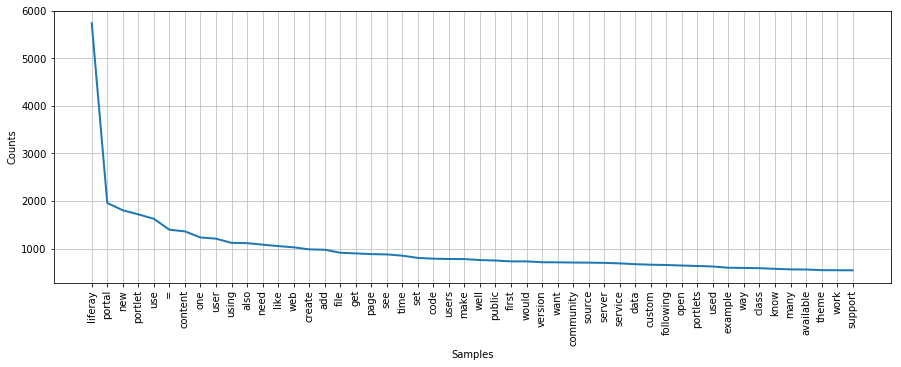

[('liferay', 5740), ('portal', 1958), ('new', 1805), ('portlet', 1719), ('use', 1626), ('=', 1396), ('content', 1361), ('one', 1233), ('user', 1208), ('using', 1119), ('also', 1114), ('need', 1082), ('like', 1052), ('web', 1026), ('create', 983), ('add', 975), ('file', 912), ('get', 898), ('page', 883), ('see', 877), ('time', 850), ('set', 803), ('code', 787), ('users', 780), ('make', 778), ('well', 758), ('public', 748), ('first', 730), ('would', 730), ('version', 712), ('want', 710), ('community', 706), ('source', 703), ('server', 699), ('service', 688), ('data', 671), ('custom', 660), ('following', 654), ('open', 643), ('portlets', 633), ('used', 623), ('example', 596), ('way', 592), ('class', 587), ('know', 573), ('many', 562), ('available', 559), ('theme', 545), ('work', 544), ('support', 542)]


In [6]:
# Read in cleaned words from last file

cleaned_blog_list = list()

file6 = open('CLEANUP 6 - Adjust Whitespace.txt', "r", encoding='utf8')
    
while True:
    title_line = file6.readline().strip()
    blog_line = file6.readline().strip()
    tag_line = file6.readline().strip()
        
    file6.readline() # This is just to burn the extra new line
    #print("Title: {}\nBlog: {}\nTags: {}\n".format(title_line, blog_line[:100], tag_line))
    
    # We only care about entries that have blog entries
    if title_line:
        #title_list.append(title_line)
        cleaned_blog_list.append(blog_line)
        #tag_list.append(tag_line)
    else:
        print("End of File")
        print("Title: {}\nBlog: {}\nTags: {}\n".format(title_line, blog_line[:100], tag_line))
        break # EOF

# Tokenize
tokens = ' '.join(cleaned_blog_list).split()

# Graph words
printMostCommonWords(tokens)


Calculating frequency of words on a per document basis. (i.e. if a document is in every document, then it has the highest frequency possible.)

In [138]:
from collections import defaultdict

# Build vocabulary set

vocab_document_count = defaultdict(lambda: 0)

for blog_words in blog_list:
    tokens = blog_words.split()
    vocab_set = set(tokens)
    
    # print('\n' + blog_words[:50])
    
    # Iterate through set, and update the vocab_document_count
    for word in vocab_set:
        vocab_document_count[word] += int(1)
        
    # Debugging: Printing all the values in the dictionary
    #for word, count in vocab_document_count.items():
    #    print("{} : {}".format(word, count))
    
    #break

# Debugging: Printing all the values in the dictionary
#for word, count in vocab_document_count.items():
#        print("{} : {}".format(word, count))
        
vocab_list = list(vocab_document_count)
word_index = {w: idx for idx, w in enumerate(vocab_document_count)}

VOCABULARY_SIZE = len(vocab_list)
DOCUMENTS_COUNT = len(blog_list)
 
print("Vocab Size: " + str(VOCABULARY_SIZE) + " Document Count: " + str(DOCUMENTS_COUNT))      # 10788, 51581

for w in sorted(vocab_document_count, key=vocab_document_count.get, reverse=True):
    print("{} : {}".format(w, vocab_document_count[w]))

Vocab Size: 28201 Document Count: 970
the : 949
to : 947
and : 940
of : 913
a : 911
in : 909
is : 881
for : 880
that : 832
this : 821
liferay : 818
with : 810
it : 808
you : 784
on : 783
be : 758
as : 752
are : 739
can : 732
have : 696
from : 689
will : 663
or : 659
we : 656
by : 630
an : 626
if : 612
all : 609
i : 594
not : 587
but : 586
your : 575
at : 571
new : 570
more : 564
so : 561
also : 546
use : 530
how : 526
about : 517
its : 513
has : 511
some : 507
one : 498
now : 490
like : 488
which : 468
there : 467
using : 463
when : 451
other : 448
portal : 446
do : 444
just : 439
here : 435
any : 430
what : 429
our : 423
make : 423
see : 419
out : 410
need : 409
get : 407
well : 400
was : 395
first : 392
time : 384
these : 382
been : 372
only : 370
them : 363
into : 357
create : 356
they : 355
want : 352
my : 349
up : 340
way : 339
would : 337
content : 337
then : 334
most : 331
should : 330
add : 325
portlet : 322
used : 320
user : 319
know : 319
many : 315
their : 310
web : 308
work

planning : 48
reference : 48
enabled : 48
overview : 48
happen : 47
internet : 47
effort : 47
format : 47
explain : 47
gets : 47
official : 47
render : 47
properly : 47
operations : 47
modules : 47
allowed : 47
velocity : 47
cheung : 47
enterprises : 47
lead : 47
requests : 47
wwwliferaycom : 47
builder : 47
size : 46
media : 46
ant : 46
unique : 46
whatever : 46
happens : 46
words : 46
fixed : 46
menu : 46
seeing : 46
avoid : 46
role : 46
style : 46
names : 46
status : 46
register : 46
chief : 46
websites : 46
moment : 45
talked : 45
havent : 45
parts : 45
administrator : 45
appropriate : 45
improved : 45
giving : 45
points : 45
specified : 45
asked : 45
previously : 45
expect : 45
state : 45
welcome : 45
helps : 45
stored : 45
advantage : 45
spring : 45
associated : 45
fully : 45
drop : 45
report : 45
member : 45
rules : 45
hi : 45
recommend : 45
concept : 45
follows : 45
logo : 45
impact : 45
ce : 45
bug : 44
seems : 44
production : 44
countries : 44
ok : 44
minutes : 44
languages :

failure : 13
postproduction : 13
git : 13
2012 : 13
closely : 12
viewed : 12
dev : 12
felt : 12
comparison : 12
stand : 12
wanting : 12
frankfurt : 12
middle : 12
fall : 12
music : 12
statistics : 12
schema : 12
visiting : 12
advantages : 12
secret : 12
analyze : 12
cas : 12
php : 12
greatest : 12
wsrp : 12
tickets : 12
p : 12
aggregate : 12
degree : 12
toward : 12
ipc : 12
gather : 12
mike : 12
university : 12
uploaded : 12
hot : 12
remotely : 12
lib : 12
netbeans : 12
<= : 12
backup : 12
pop : 12
fails : 12
proven : 12
rays : 12
character : 12
tons : 12
grown : 12
distribute : 12
engines : 12
ton : 12
act : 12
tedious : 12
replacing : 12
reusable : 12
win : 12
evaluation : 12
constantly : 12
tied : 12
essentially : 12
removing : 12
visitors : 12
microsystems : 12
griffin : 12
bringing : 12
discover : 12
redirected : 12
officially : 12
causes : 12
continuous : 12
nowadays : 12
glassfish : 12
webbased : 12
jdbc : 12
apple : 12
stores : 12
scheduling : 12
defaults : 12
algorithm : 12
li

alternatively : 6
devliferaycom : 6
esther : 6
vary : 6
segments : 6
ambientia : 6
blade : 6
gradle : 6
buildgradle : 6
icesoft : 5
aimed : 5
fruits : 5
sponsored : 5
italy : 5
prices : 5
remarks : 5
stood : 5
fortunate : 5
filling : 5
gathered : 5
watching : 5
installer : 5
streaming : 5
measures : 5
2gb : 5
geography : 5
tone : 5
37 : 5
rates : 5
payment : 5
camera : 5
cutting : 5
crisis : 5
listened : 5
cheaper : 5
pc : 5
facts : 5
south : 5
promising : 5
aptget : 5
rootxml : 5
vacation : 5
wife : 5
suresh : 5
mr : 5
rc : 5
rightclick : 5
understandable : 5
drawbacks : 5
decides : 5
weekend : 5
resize : 5
uploads : 5
signon : 5
binaries : 5
processors : 5
reboot : 5
dual : 5
mount : 5
textarea : 5
subversion : 5
edits : 5
renewed : 5
pace : 5
relying : 5
catching : 5
confident : 5
remainder : 5
excerpt : 5
cold : 5
genuine : 5
magically : 5
pressure : 5
lose : 5
breath : 5
dot : 5
hacked : 5
attractive : 5
thin : 5
distinct : 5
cookies : 5
truth : 5
hisher : 5
grouped : 5
64bit : 5


firebug : 3
treatment : 3
profiles : 3
sea : 3
coworker : 3
24th : 3
spell : 3
100000 : 3
portuguese : 3
swedish : 3
finnish : 3
scayt : 3
amongst : 3
retail : 3
dominated : 3
arranged : 3
markers : 3
$void : 3
expandocolumnconstantsstring : 3
expandotable : 3
programatically : 3
featurerich : 3
surprising : 3
dcomsunmanagementjmxremoteauthenticate=false : 3
jvms : 3
$1 : 3
collective : 3
sla : 3
satisfies : 3
longstanding : 3
transportation : 3
historic : 3
coincidence : 3
fed : 3
sr : 3
lms : 3
steady : 3
10th : 3
lgpl : 3
birds : 3
compromise : 3
blocking : 3
threadlocal : 3
ruin : 3
archetype : 3
proxies : 3
portalimpl : 3
portalclient : 3
liferayautodeploydir : 3
jcrhook : 3
javas : 3
sbtostring : 3
jdks : 3
stringbundler : 3
decorator : 3
married : 3
tastes : 3
dreams : 3
etclast : 3
docbook : 3
defaultxml : 3
$tomcatasdirwebappscreate : 3
$tomcatasdir : 3
$sharedwar : 3
utf8grant : 3
portalextpropertiesdlhookimpl=comliferaydocumentlibraryutilcmishookcmiscredentialsusername=admin

equipping : 2
revenuegenerating : 2
sellers : 2
carl : 2
hip : 2
265 : 2
canadian : 2
competitor : 2
contender : 2
colorado : 2
fview : 2
uicomponent : 2
xmlhttprequest : 2
triplet : 2
ajaxified : 2
javaioserializable : 2
inserts : 2
edoras : 2
mpl : 2
hpanelgrid : 2
serialversionuid : 2
repos : 2
remainer : 2
encapsulated : 2
premiere : 2
copyright : 2
templating : 2
normalized : 2
expandocolumns : 2
comliferayportalkerneleventsactionexception : 2
dcne : 2
comliferayportalkernelutilgetterutil : 2
comliferayportletexpandomodelexpandotable : 2
manipulated : 2
comliferayportletexpandoserviceexpandotablelocalserviceutil : 2
duplicatetablenameexception : 2
expandotablelocalserviceutilgettable : 2
comliferayportletexpandoserviceexpandocolumnlocalserviceutil : 2
expandocolumnlocalserviceutiladdcolumn : 2
comliferayportletexpandomodelexpandocolumnconstants : 2
shun : 2
duplicatecolumnnameexception : 2
dtne : 2
prettier : 2
jms : 2
xxpermsize=128m : 2
xms1024m : 2
marketleading : 2
championed 

newbies : 2
toolbox : 2
pulldown : 2
possesses : 2
tincan : 2
inserting : 2
alloyeditor : 2
visualizing : 2
exploratory : 2
gogo : 2
javaee : 2
relevants : 2
oven : 2
automation : 2
flat : 2
compel : 2
incentives : 2
p1 : 2
wo : 2
disappear : 2
overloads : 2
bakker : 2
minus : 2
alternate : 2
omnichannel : 2
adults : 2
glyph : 2
lieu : 2
fa : 2
artist : 2
auicss : 2
canned : 2
cup : 2
weeding : 2
personas : 2
tying : 2
dataset : 2
prototypes : 2
fetched : 2
illustrator : 2
god : 2
baked : 2
sticks : 2
demanded : 2
378 : 2
allocation : 2
8099 : 2
maclinux : 2
tomcatusersxml : 2
srctest : 2
testjava : 2
$tomcathomeconf : 2
manifest : 2
254 : 2
portletclass : 2
babel : 2
es2015 : 2
ie9+ : 2
createconfigure : 2
auxiliary : 2
engages : 2
motivating : 2
instructional : 2
atlas : 2
mobilefriendly : 2
purposefully : 2
facescontext : 2
applicant : 2
categorized : 2
farreaching : 2
+100 : 2
postgres : 2
createuser : 2
kit : 2
sprd : 2
createdb : 2
postgresqlcontrib : 2
consumible : 2
intensively

unpaid2 : 1
astounded : 1
shudder : 1
shanghai : 1
observations1 : 1
mssql : 1
superlightweigth : 1
generalas : 1
inhibit : 1
interestind : 1
problemsif : 1
appropiated : 1
taska : 1
validations : 1
doeslets : 1
alvaro : 1
wikiby : 1
comewe : 1
knowso : 1
lep6726 : 1
subtask : 1
therell : 1
activies : 1
glassfishfeedback : 1
hereglassfish : 1
usersglassfishdevjavanetplease : 1
scanner : 1
trunk6 : 1
hotdeploy : 1
location7 : 1
gfv21 : 1
present7 : 1
145 : 1
all8 : 1
sourceforgenet : 1
openssozip : 1
email5 : 1
gfv3 : 1
installation4 : 1
machines4 : 1
joebloggs : 1
path5 : 1
appserverproperties : 1
deployablewar : 1
enterpriseadmin : 1
portalhost : 1
openssowar : 1
id=joebloggs : 1
it3 : 1
fine6 : 1
email=testliferaycomnote : 1
howtos : 1
liferaycoms : 1
shpiel : 1
philosophical : 1
appeals : 1
stringred : 1
stringblue : 1
foolist : 1
getfoolist : 1
comliferayportalkernelutilportalclassinvoker : 1
applicationscopebean : 1
foolistaddnew : 1
comfooliferaystartup : 1
globalstartupevents=co

incase : 1
servicesfrom : 1
customerdtls : 1
itcreating : 1
lain : 1
grinders : 1
1s : 1
networkok : 1
5sto : 1
recorder : 1
harddiver : 1
network1gbssoftware : 1
backgroup : 1
25s : 1
gbs : 1
dreamin : 1
10s : 1
releasepreparationbefore : 1
netinterface : 1
togetherps : 1
jython : 1
scenariosetup : 1
cores : 1
1gbs : 1
pagethis : 1
kindness : 1
tooltechnically : 1
bottleneckhardware : 1
liferayi : 1
pageas : 1
loginrun : 1
cent : 1
poeple : 1
grinder : 1
eighteen : 1
hubs : 1
weissglas : 1
wwwkanal5se : 1
kanal5s : 1
240000 : 1
microsite : 1
toggling : 1
swedens : 1
rising : 1
swedenkanal5se : 1
kanal5se : 1
broaden : 1
attributed : 1
kanal : 1
straining : 1
peaks : 1
jspsportlet : 1
portalpack : 1
302introduction : 1
entires : 1
saveright : 1
folderhtml : 1
522 : 1
project> : 1
hookprovide : 1
itportalproperties : 1
liferayavailable : 1
projectright : 1
projectwhich : 1
projectin : 1
wroopa : 1
htmlcommonthemesbottomextjspnow : 1
informationto : 1
woopra : 1
breakout : 1
indialiferay

havecomliferayportletmessageboardslarmbportletdatahandlerimplthe : 1
categoriessubproduct : 1
screenshotarchive : 1
articlesimport : 1
more>configuration : 1
$tomcatasdirwebappsrootportalroothomewebinfliferayportletxmlcomliferayportletmessageboardsactionconfigurationactionimplfortunately : 1
filesyou : 1
larwhy : 1
followsdocbook : 1
titleanswer : 1
larabstracted : 1
infoco : 1
sp3introduction : 1
stepslocate : 1
issueswhatre : 1
filesarchive : 1
articlesexamples : 1
editarchivedsetupsjsp : 1
18th : 1
inteligente : 1
diferencialill : 1
tecnología : 1
estrategia : 1
conseguir : 1
experiencia : 1
soluciones : 1
soure : 1
loses : 1
opting : 1
escrow : 1
outpace : 1
$300 : 1
openmq : 1
purposely : 1
springframework : 1
integrationinteroperability : 1
advertise : 1
emergencies : 1
advocacy : 1
commodity : 1
proposing : 1
analyzer : 1
sesamestreetcom : 1
bulletinsalerts : 1
becuase : 1
troubled : 1
foothold : 1
manageability : 1
enteprise : 1
procurement : 1
collaboratively : 1
monopolisitc 

dataimplement : 1
upgradecustom : 1
remotelythis : 1
portletpreferencesprotected : 1
comliferayknowledgebaseadminlaradminportletdatahandlerimplnote : 1
serverprotecting : 1
comliferayknowledgebaseadminlaradminportletdatahandlerimplin : 1
servletof : 1
comliferayportalkernellarbaseportletdatahandler : 1
portletdatahandlercontrol : 1
exportdata : 1
getexportcontrolspublic : 1
categoriescustom : 1
importdata : 1
anypolls : 1
69198171104 : 1
linksimages : 1
pluginshow : 1
rowid : 1
objectid4d292945bda2c08a06e35e67 : 1
dbgetcollectionaccountstableaccountstablecount : 1
dbgetcollectioncomliferayportalmodelusercustomfieldsfind : 1
lportal10135 : 1
17313 : 1
daffy : 1
17205 : 1
valueid : 1
comliferayportalmodelusercustomfields : 1
lportal0 : 1
classnameid : 1
mongo : 1
excelent : 1
expandomongodbhook : 1
dbgetcollectionaccountstableaccountstablefind : 1
hype : 1
systemindexes : 1
1294543192848 : 1
10135 : 1
opperations : 1
10173 : 1
removedupdated : 1
duck : 1
objectid4d28f318fcfcc08a7855ebe4 

dlrecordlog : 1
nonsignedin : 1
dlrecorddefinitionissigninrequired : 1
responsesendredirectthemedisplaygeturlsignin : 1
assetlinks : 1
documentdownloads : 1
additiona : 1
dlrecord : 1
88826 : 1
yearly : 1
dlrecorddefinition : 1
dlrecorddefinitiongetdefinitionid : 1
portalcontextconfiglocation : 1
inconvenience : 1
mylocalserviceutildoxyz : 1
contextloaderlistener : 1
bore : 1
worrying : 1
constraintslimitations : 1
mylocalservice : 1
depencies : 1
webinfapplicationcontextxml : 1
configs : 1
occassion : 1
applicationcontexts : 1
jee : 1
injecting : 1
webinfclassesmetainfkaleospringxmlwebinfclassesmetainfmessagingspringxml : 1
practitioners : 1
mylocalserviceutil : 1
westcoastsymposium : 1
namespacing : 1
ilyian : 1
tagbuilder : 1
capitalization : 1
yuilibrarycom : 1
jsrosettastone : 1
ontario : 1
disseminating : 1
stumbling : 1
jt : 1
counterproductive : 1
wcms : 1
publically : 1
familiy : 1
nightlytrunk : 1
midnovember : 1
firstclass : 1
nag : 1
relabelled : 1
patchtool : 1
mistaken : 

$liferaymavenpluginversion : 1
liferaymavenpluginversion : 1
$liferayversion : 1
$liferayautodeploydir : 1
comliferaymavenplugins : 1
$liferaythemeparent : 1
liferayappserverxxx : 1
$liferayappserverdeploydir : 1
mojos : 1
$liferaythemetype : 1
6130 : 1
liferaymavenplugin : 1
$liferayappserverportaldir : 1
$liferayappserverlibglobaldir : 1
tease : 1
sf : 1
freenode : 1
edward : 1
9+10 : 1
ussf : 1
16+17 : 1
coincidences : 1
minis : 1
criterias : 1
$smsnumbergetdata : 1
$smsprefix : 1
devicegetcapabilityxhtmlmakephonecallstring> : 1
dsl : 1
$devicegetcapabilityxhtmlsendsmsstring : 1
smsprefix : 1
devicegetcapabilityxhtmlsendsmsstring> : 1
$callprefix : 1
$phonenumbergetdata : 1
getcapabilityjavalangstring : 1
$candophonecalls : 1
none> : 1
devicedetectionutil : 1
ist : 1
cansendsms : 1
callprefix : 1
$devicegetcapabilityxhtmlmakephonecallstring : 1
delegated : 1
candophonecalls : 1
$cansendsms : 1
presense : 1
specialize : 1
offshoring : 1
sivaraman : 1
biz : 1
inviting : 1
preetam : 1


arraylist> : 1
mbmessage : 1
mbcategorylocalserviceutilgetcategoriesthemedisplaygetscopegroupid : 1
prints : 1
categorygetname : 1
categoryid : 1
formbcategory : 1
millestone : 1
retake : 1
hoops : 1
stressfree : 1
promo : 1
anxiety : 1
agonizing : 1
accompanying : 1
relive : 1
31st : 1
backgroundtaskstatusregistryutilgetbackgroundtaskstatus : 1
taskcontextmap : 1
xy : 1
liferaybackgroundtaskstatus : 1
executor : 1
mybackgroundtaskstatusmessagetranslator : 1
messagebusutilsendmessagedestinationnamesbackgroundtaskstatus : 1
handleexceptionbackgroundtask : 1
backgroundtasklocalserviceutiladdbackgroundtask : 1
backgroundtaskstatussetattribute : 1
servletcontextnames : 1
backgroundtaskgettaskcontextmap : 1
backgroundtaskconstants : 1
taskexecutorclassname : 1
setbackgroundtaskstatusmessagetranslator : 1
backgroundtaskresult : 1
setserialtrue : 1
backgroundtaskexecutor : 1
backgroundtaskstatusmessagetranslator : 1
thurzos : 1
statusmessage : 1
threading : 1
isserial : 1
backgroundtaskstatus

namesids : 1
destroying : 1
renderrequests : 1
porcessaction : 1
168286 : 1
mime : 1
filewar : 1
setproperty : 1
twostep : 1
jts : 1
widow : 1
initportletconfig : 1
container+application : 1
accommodated : 1
entando : 1
jdoconnection : 1
portalcontext : 1
wil : 1
lyfecycle : 1
severs : 1
restarts : 1
objectsresources : 1
texthtmlxml : 1
minimized : 1
differed : 1
getproperty : 1
javaxportlet : 1
instantiationserving : 1
destroy : 1
servicepacks : 1
supportrelated : 1
unfriend : 1
zsigmondrab : 1
zsigmond : 1
tongueincheek : 1
joked : 1
hotfixes : 1
sweden : 1
jbalsas : 1
editingcreating : 1
webstorm : 1
themeworkshop : 1
emils : 1
overlaps : 1
threeway : 1
emiloberg : 1
onpremise : 1
relic : 1
logstash : 1
compuware : 1
appdynamics : 1
elkstack : 1
brettswaim : 1
sigvartsen : 1
valet : 1
devon : 1
usergroup : 1
stiansigvartsen : 1
stians : 1
intergalactiv : 1
adventures : 1
thebryanho : 1
bridging : 1
audiovisual : 1
intergalactic : 1
hyades : 1
mascot : 1
ho : 1
googlbitly : 1
alphanu

literals : 1
webpack : 1
babeljs : 1
const : 1
explosion : 1
destructuring : 1
ecma2623 : 1
axel : 1
tc39 : 1
ie11 : 1
rauschmayer : 1
es5 : 1
shortlisted : 1
es3 : 1
ecma2625 : 1
transpile : 1
transpilaton : 1
requirejs : 1
phenomenizer : 1
competences : 1
nesting : 1
phenomizer : 1
portletyou : 1
subparagraph : 1
subordinate : 1
selfestimates : 1
pptx : 1
minutebyminute : 1
mathematical : 1
youtubetincan : 1
verb : 1
variant : 1
rewinding : 1
mobiles : 1
analytic : 1
classrooms : 1
centricity : 1
amobile : 1
contenteither : 1
autogenerates : 1
prefers : 1
pinterest : 1
definedand : 1
hundredths : 1
040 : 1
replaceable : 1
codeas : 1
versionedapi : 1
peychevs : 1
7it : 1
makingcalled : 1
storages : 1
+180 : 1
estate : 1
picks : 1
confession : 1
upgradesboth : 1
flicker : 1
outofthe : 1
themeof : 1
portletwidget : 1
imagesan : 1
disappoint : 1
etchosts : 1
sslciphers : 1
5m : 1
sslcertificatekey : 1
skipping : 1
$proxyaddxforwardedfor : 1
liferayspexamplecom : 1
$status : 1
highanullmd

javascriptsinglepageapplicationenabled=false : 1
sennajss : 1
submissions4 : 1
unloaded23 : 1
commandlinks : 1
unload : 1
datasennaoff : 1
commandlink : 1
hlink : 1
houtputlink : 1
blinking : 1
tag1 : 1
microstrategy : 1
infer : 1
foodmart : 1
underutilized : 1
d3 : 1
multidimensional : 1
calcite : 1
olap : 1
mdx : 1
olap4j : 1
xmla : 1
avatica : 1
saiku : 1
pivot4j : 1
drilldown : 1
jpivot : 1
sas : 1
geomondrian : 1
nightmares : 1
cognos : 1
forks : 1
datatables : 1
traction : 1
kylin : 1
select2 : 1
hadoop : 1
mvcrendercommand : 1
servicerankinginteger=100 : 1
mvccommandname=view : 1
comliferayjournalexportimportdatahandlerjournalportletdatahandler : 1
2go : 1
postloginlifecycleaction : 1
prelogin : 1
mvcrendercommandclass : 1
1create : 1
journalportletdatahandler : 1
servicerankinginteger=10 : 1
journalportletkeysjournal : 1
sampleusermodellistener : 1
javaxportletname= : 1
customizeoverride : 1
javaxportletname=yourportletnameid : 1
mvcactioncommandclass : 1
mvcactioncommand : 1
e

Cleanup the data by removing stopwords, or haplax legomenon

In [139]:
# Remove Low Frequency & High Frequency Words

low_frequency_word_list = list()
high_frequency_word_list = list()

LOW_FREQUENCY_LIMIT_INCLUSIVE = 4
HIGH_FREQUENCY_LIMIT_INCLUSIVE = 500

unique_words_before = len(vocab_document_count)

# Iterate through document frequency dictionary, and remove all low frequency instances
for word in list(vocab_document_count.keys()):
    
    if vocab_document_count[word] <= LOW_FREQUENCY_LIMIT_INCLUSIVE:
        del vocab_document_count[word]
        low_frequency_word_list.append(word)
        
unique_words_after = len(vocab_document_count)

print("Length (before): {}, Length (after): {}".format(unique_words_before, unique_words_after))
    
# vocab_document_count = vocab_document_count_removed_low_limit

Length (before): 28201, Length (after): 4728


Obtaining Q1, Q2, Q3, Q4

In [140]:
number_of_entries = len(vocab_document_count)
max_index = number_of_entries - 1
min_index = 0
q2_index = int(number_of_entries / 2)
q1_index = int(q2_index / 2)
q3_index = q2_index + q1_index

sorted_word_list = sorted(vocab_document_count, key=vocab_document_count.get, reverse=False)

print("Min: {} ({})".format(sorted_word_list[min_index], vocab_document_count[sorted_word_list[min_index]]))
print("Q1:  {} ({})".format(sorted_word_list[q1_index], vocab_document_count[sorted_word_list[q1_index]]))
print("Q2:  {} ({})".format(sorted_word_list[q2_index], vocab_document_count[sorted_word_list[q2_index]]))
print("Q3:  {} ({})".format(sorted_word_list[q3_index], vocab_document_count[sorted_word_list[q3_index]]))
print("Q4:  {} ({})".format(sorted_word_list[max_index], vocab_document_count[sorted_word_list[max_index]]))
      
      #Max: {} ({})".format(vocab_document_count[min_index]))


Min: icesoft (5)
Q1:  correspond (7)
Q2:  workspace (14)
Q3:  processes (35)
Q4:  the (949)


In [141]:
# Plotting the Data

#plt.bar(range(len(vocab_document_count)), vocab_document_count.values(), align='center')
#plt.xticks(range(len(vocab_document_count)), vocab_document_count.keys())

#plt.show()

# Calculate Stats on the distro
###############################
document_frequency_list = list(vocab_document_count.values())

# Calcuate Mean, Median, Stdev
import numpy as np

mean = np.mean(document_frequency_list)
median = np.median(document_frequency_list)
std_dev = np.std(document_frequency_list)

print("Mean: {}\nMedian: {}\nStandard Deviation: {}".format(mean, median, std_dev))

# Graph data
############
import matplotlib as mpl
import matplotlib.pyplot as plt 

# Clear previous instances
plt.clf()

# Create a figure instance
fig = plt.figure(1, figsize=(9, 6))

# Create an axes instance
ax = fig.add_subplot(111)

# Create the boxplot
bp = ax.boxplot(document_frequency_list)
ax.set_yscale('log')

# Save the figure
fig.savefig('Vocab Frequency by Documents.png', bbox_inches='tight')

Mean: 40.62542301184433
Median: 14.0
Standard Deviation: 85.78460861065145


Calculate (Inverse) Document Frequency

In [272]:
from collections import defaultdict
word_df = defaultdict(lambda: 0)

for blog_words in blog_list:
    tokens = blog_words.split()
    word_set = set(tokens)
    
    for word in word_set:
        word_df[word] += 1

import math
for word in vocab_list:
    if word_df[word] >= 2:
        #word_df[word] = math.log((word_df[word] + 1) / len(blog_list))
        word_df[word] = word_df[word] / len(blog_list)
    
#counter = 0
#for word in word_df:
#    print("Word: {} - {}".format(word, word_df[word]))
    
#    if counter > 10:
#        break
#    else:
#        counter += 1
        
sorted_list = sorted(word_df.items(), key=lambda x:x[1])

word_list = []
log_score_list = []

raw_count_list = []

for entry in sorted_list:
    print("{} - {}".format(entry[0], entry[1]))
    word_list.append(entry[0])
    log_score_list.append(entry[1])
    
    if entry[1] >= 2:
        raw_count_list.append(entry[1])
    
#word_list = [x[0] for x in sorted_list]
#log_score_list = [x[1] for x in sorted_list]

#print(word_list[2])
#print(word_list[3])
#print(log_score_list[2:])

7102007 - 1
37000 - 1
redly2001 - 1
dialogs - 1
liferayicefaces - 1
12142006 - 1
componentrelated - 1
7232007 - 1
portalicefaces - 1
waters - 1
roth - 1
frameworkrelated - 1
431 - 1
unfornately - 1
literay - 1
grave - 1
ripping - 1
disadvantages - 1
blazingly - 1
securities - 1
crop - 1
fao - 1
luxury - 1
agriculture - 1
colosseo - 1
prevailing - 1
massimo - 1
9600 - 1
corn - 1
web2fordev - 1
circo - 1
farmers - 1
rural - 1
baud - 1
flashbased - 1
unreliable - 1
dial - 1
yao - 1
preschooler - 1
coworkermy - 1
weakening - 1
painfully - 1
berserk - 1
rmb - 1
mapand - 1
foreigner - 1
pigments - 1
dui - 1
acknowledgement - 1
laughed - 1
properlyi - 1
bu - 1
skull - 1
shi - 1
awaiting - 1
teller - 1
sunk - 1
trickled - 1
helpless - 1
snide - 1
flinch - 1
pai - 1
disgust - 1
mute - 1
dawned - 1
jin - 1
differentiated - 1
crispy - 1
vengeance - 1
ahem - 1
kroq - 1
1bedroom - 1
foolio - 1
satellite - 1
spacious - 1
turkish - 1
ö - 1
swamped - 1
yogurt - 1
10minute - 1
callie - 1
tomfoolery - 1

clarification - 1
substituting - 1
htmlcode - 1
javacode - 1
tinymce - 1
appearances - 1
germinus - 1
assetdata - 1
deri - 1
reseach - 1
upm - 1
lifelets - 1
roma - 1
eurpean - 1
consortiums - 1
reusal - 1
imola - 1
institution - 1
ici - 1
irish - 1
asseenontv - 1
44based - 1
sounding - 1
teamweve - 1
presses - 1
cooler - 1
lifecastsonline - 1
blurb - 1
lyons - 1
fond - 1
forewarned - 1
ifi>pagescontinue - 1
<=i> - 1
curvalue+7 - 1
curvalue - 1
htmltaglibuipageiteratorpagestartjsp - 1
maxpages - 1
pagesiteratorbegin - 1
pagesiteratorend - 1
pagesiteratormax - 1
paginators - 1
curvalue7 - 1
i<1 - 1
numberformatformatpages - 1
everytihg - 1
preexistent - 1
posibility - 1
posibilities - 1
impresive - 1
pragmatists - 1
moneygenerating - 1
springhibernate - 1
java5 - 1
supportconsultants - 1
piss - 1
idealists - 1
quirks - 1
whove - 1
whyfloss - 1
seville - 1
bilbao - 1
spamming - 1
announcementalert - 1
acheived - 1
lightly - 1
timestamped - 1
locatized - 1
broacast - 1
inscription - 1
cou

hoot - 1
versionlayoutimplobject - 1
tomodellayoutsoap - 1
comliferayportalmodelimpllayoutmodelimpl - 1
toescapedmodel - 1
wrappedlist - 1
clonesetplidgetplid - 1
layoutmodelimpl - 1
comrayportalmodelimpl - 1
comrayportalserviceaop - 1
modelimpl - 1
methodinterceptor - 1
apsect - 1
orgaopallianceinterceptmethodinterceptor - 1
superlist - 1
getint - 1
throwable - 1
equalsobject - 1
isescapedmodel - 1
invokemethodinvocation - 1
versionlayoutimplclonelayoutmodelimplobject - 1
versionlayoutimpl - 1
layoutlocalserviceinterceptor - 1
invocationproceed - 1
comrayportalmodelimplversionlayoutimpl - 1
soapmodel - 1
clonesetplidlayoutgetplid - 1
clonelayoutmodelimpl - 1
wrappedlistlist - 1
wraplayoutobject - 1
modelsetplidsoapmodelgetplid - 1
comparetoobject - 1
modelsetnewisnew - 1
othewise - 1
reporter - 1
inappropriate - 1
inappropiate - 1
communityorganization - 1
import=javaxportlet> - 1
customerdtlslocalserviceutiladdcustomerdtlscustomer - 1
import=comexamplecustomerservice> - 1
requestgetp

coles - 1
416 - 1
renewal - 1
hasslefree - 1
insurancerelated - 1
nicholasscofieldallianzcomau - 1
outshone - 1
088 - 1
414 - 1
featureset - 1
australian - 1
vodacom - 1
ea - 1
arts - 1
anthony - 1
dashboarding - 1
onsiteoffshore - 1
ogs - 1
comcast - 1
csc - 1
14088869932 - 1
medco - 1
caliber - 1
nortel - 1
unisys - 1
activision - 1
$kbdldefaultrootfoldername$articleidenus - 1
rowitem - 1
kbdefaultgrouporganizationenabled=true - 1
kbdefaultgrouporganizationenabled - 1
kbigdefaultfolderlanguaguedescription=knowledge - 1
kbigdefaultrootfoldername=kbighome - 1
kbigdefaultrootfolderdescription=knowledge - 1
specfic - 1
kbdefaultgrouporganizationname=knowledge - 1
kbdefaultvocabularyname=knowledge - 1
$kbigdefaultrootfoldername$articleidenus - 1
kbdldefaultrootfolderdescription=knowledge - 1
dede - 1
kbdldefaultrootfoldername=kbdlhome - 1
ig - 1
wholeheartedly - 1
europespan> - 1
hungarya - 1
akos - 1
outreach - 1
gabriel - 1
quarters - 1
akosgabrielliferaycom - 1
cultivating - 1
explosiv

pounding - 1
choke - 1
uhwow - 1
robe - 1
hooded - 1
screamed - 1
tightening - 1
recluse - 1
crutch - 1
obscured - 1
friendsany - 1
brownmixedwithgold - 1
choked - 1
violently - 1
replenished - 1
prose - 1
somethingsomething - 1
mountains - 1
smelled - 1
growled - 1
squeezed - 1
facial - 1
divorced - 1
despised - 1
selfishif - 1
urgency - 1
asleep - 1
unkempt - 1
stomach - 1
gasping - 1
hid - 1
sputtered - 1
moneybut - 1
gingerly - 1
glowing - 1
overpowering - 1
onea - 1
rivers - 1
goo - 1
squirm - 1
anecdote - 1
melt - 1
tended - 1
ate - 1
wisely - 1
waswas - 1
lovable - 1
melted - 1
smellwhatever - 1
wha - 1
breathe - 1
responsibly - 1
pondered - 1
castle - 1
glow - 1
unwashed - 1
robes - 1
whim - 1
zeroed - 1
noticing - 1
statues - 1
sticky - 1
buildings - 1
darker - 1
pennsylvania - 1
wives - 1
toads - 1
dayand - 1
niceties - 1
prematurely - 1
hue - 1
dreambecause - 1
chocolatelike - 1
flowed - 1
praise - 1
signaled - 1
panicked - 1
pocono - 1
monuments - 1
bequeath - 1
island - 1


mvkztv6o40+sref595+gedmoo8= - 1
samlrequiressl=false - 1
st=unknown - 1
samlidpauthnrequestsignaturerequired=true - 1
samlkeystorecredentialpasswordliferaysamlidpdemo=liferay - 1
assetion - 1
samlkeystorepassword=liferay - 1
aajsdf8djv5xqw6ty1msg7 - 1
liferaysamlidpdemo - 1
liferayhomedatakeystorejks - 1
samlkeystorepath=$liferayhomedatakeystorejks - 1
cn=liferay - 1
relaystate - 1
liferaysamlidpdemocrt - 1
locality - 1
collegues - 1
samlrole=idp - 1
o=liferay - 1
liferayhomedatasamlsalesforcemetadataxml - 1
samlsignmetadata=true - 1
samlentityid=liferaysamlidpdemo - 1
l=unknown - 1
oxvqw== - 1
c=unknown - 1
nameidentifier - 1
datakeystorejks - 1
miidjj - 1
samlmetadatapaths=$liferayhomedatasamlsalesforcemetadataxml - 1
samlidpmetadataattributesenabledhttpssamlsalesforcecom=true - 1
miidjjccanagawib - 1
issuer - 1
samlidpmetadatanameidformathttpssamlsalesforcecom=urnoasisnamestcsaml11nameidformatunspecified - 1
entityid - 1
samlidpmetadatasalesforceattributesenabledhttpssamlsalesforcec

organizationsearchaction - 1
entityemailaddresses - 1
websitesclassname - 1
organizationsearchactionjava - 1
entityservices - 1
htmlportletdirectoryorganizationphonenumbersjsp - 1
entityphones - 1
htmlportletdirectoryorganizationservicesjsp - 1
beanparamutilgetlongorganization - 1
paramutilgetlongrenderrequest - 1
organizationlocalserviceutilgetorganizationorganizationid - 1
mainsearchresultformjsp - 1
portleturlrequestgetattribute - 1
htmlportletdirectorycommonadditionalemailaddressesjsp - 1
currenturl - 1
phonesclassname - 1
comliferayportalhookaction - 1
entitywebsites - 1
requestsetattributewebkeysorganization - 1
entityaddresses - 1
strutsactionimpl - 1
comliferayportalserviceorganizationlocalserviceutil - 1
htmlportletdirectoryorganizationcommentsjsp - 1
freedman - 1
manfred - 1
webbeans - 1
requestscoped - 1
jozef - 1
muir - 1
finnegan - 1
riem - 1
stateless - 1
roger - 1
pete - 1
portletspec - 1
weld - 1
kitain - 1
legends - 1
jsr329 - 1
silvert - 1
stateful - 1
hartinger - 1
c

servicecontextfactorygetinstancerequest - 1
categorygetname - 1
mbmessageserviceutiladdmessage - 1
appropriated - 1
millestone - 1
retake - 1
accompanying - 1
stressfree - 1
agonizing - 1
relive - 1
promo - 1
anxiety - 1
hoops - 1
refined - 1
backgroundtaskthreadlocalgetbackgroundtaskid - 1
backgroundtaskid - 1
backgroundtaskstatusregistryutilgetbackgroundtaskstatus - 1
setbackgroundtaskstatusmessagetranslator - 1
servletcontextnames - 1
executebackgroundtask - 1
systemoutprintlnbackgroundtaskstatusgetattributexy - 1
thurzos - 1
basebackgroundtaskexecutor - 1
backgroundtaskstatus - 1
xy - 1
backgroundtasklocalserviceutiladdbackgroundtask - 1
messagebusutilsendmessagedestinationnamesbackgroundtaskstatus - 1
mybackgroundtaskstatusmessagetranslator - 1
threading - 1
executor - 1
handleexceptionbackgroundtask - 1
backgroundtaskexecutor - 1
isserial - 1
taskexecutorclassname - 1
statusmessage - 1
backgroundtaskgettaskcontextmap - 1
taskcontextmap - 1
getbackgroundtaskstatusmessagetranslator

expandovaluelocalserviceutil - 1
expandovaluelocalserviceutiladdvalue - 1
expandotablelocalserviceutiladdtablecompanyid - 1
columnnames - 1
htmljspsaddemployeejsp - 1
expandovaluelocalserviceutilgetdata - 1
nste - 1
<=expandovaluelocalserviceutilgetdata - 1
addtablecompanyid - 1
databasetablename - 1
getportletsessionemployeeaddsuccess> - 1
gettable - 1
expandorowlocalserviceutilgetrows - 1
fieldlabel - 1
addcolumn - 1
classed - 1
infoemployee - 1
getnameliferayexpandoapiactionexpandotablename - 1
companyid=themedisplaygetcompanyid - 1
liferayexpandoapiactioncolumnnames4 - 1
employeefirstname - 1
expandocolumnlocalserviceutiladdcolumntableidfieldnameexpandocolumnconstantsstring - 1
message=table - 1
infoexpandotable+expandotablegettableid - 1
expandocolumnconstants - 1
5classpk - 1
4classpk - 1
absurd - 1
ecma262 - 1
15931 - 1
cf - 1
0gethours - 1
midnightless - 1
millisecond - 1
spidermonkey - 1
date2015 - 1
115959 - 1
americasaopaulo - 1
sizeable - 1
considers - 1
equality - 1
strike

hotspottm - 1
typesafereleases - 1
databasename - 1
valamisvalamishooktargetscala210learnliferay620hookwar - 1
serverlog - 1
xxmaxpermsize=512m - 1
siteadministration - 1
14+ - 1
17071 - 1
⇒ - 1
~sbt - 1
sbts - 1
pgadmin - 1
17071b14 - 1
freshly - 1
quizes - 1
2471b01 - 1
6210+ - 1
sbt - 1
pgadmin3 - 1
liferayxxxtomcatxxxbin - 1
upwards - 1
sbtversion - 1
cunning - 1
binstartupsh - 1
valamislrs - 1
permgen - 1
0138 - 1
valamistheme - 1
typesafesnapshots - 1
valamislearnportlettargetscala210learnportletwar - 1
valamislrsliferaytargetscala210valamislrsportletwar - 1
willingly - 1
abdon - 1
forked - 1
startedusing - 1
segmentation - 1
notifies - 1
exploiting - 1
hotswitch - 1
marketers - 1
enterpriseoriented - 1
techy - 1
perfomed - 1
salesmen - 1
blaze - 1
ne - 1
formyou - 1
fool - 1
struture - 1
templateftl - 1
$curtitlegetdata - 1
restcontroller - 1
customerrepository - 1
paging - 1
datagrid - 1
chunks - 1
postman - 1
sortable - 1
pageddatasource - 1
polyfill - 1
polymer - 1
persitsten

amidst - 1
swimming - 1
flywheel - 1
mouthfuls - 1
applicationmoduleanywhere - 1
experiementing - 1
trafficking - 1
rahabsdaughtersorg - 1
bubbling - 1
grannan - 1
multiasset - 1
searchcentric - 1
awardees - 1
asparagus - 1
publishable - 1
sombre - 1
thirtyminute - 1
superexcited - 1
rahabs - 1
marshalling - 1
propel - 1
shirt - 1
stagingpublication - 1
neo4j - 1
xml<>object - 1
experiential - 1
topological - 1
pulse - 1
basicjaxrssampleapplication - 1
exemplars - 1
whittled - 1
messagebodyreader - 1
dreamy - 1
attaches - 1
corbin - 1
utocomplete - 1
colombian - 1
fostering - 1
sergios - 1
oliveira - 1
brew - 1
aromatic - 1
trout - 1
decisionschoices - 1
teenagers - 1
toolwidget - 1
fosters - 1
sew - 1
swagger - 1
daughers - 1
peace - 1
bagel - 1
invocations - 1
interviewing - 1
schemaorg - 1
lent - 1
potholes - 1
murakami - 1
getsingletons - 1
afresh - 1
messagebodywriter - 1
awardee - 1
mapwhoa - 1
curlinitiated - 1
creamcheese - 1
coffmangraham - 1
andre - 1
sailing - 1
tailormade -

nod - 2
upstarts - 2
reflecting - 2
crossroads - 2
themedisplaygetplid - 2
salad - 2
meanings - 2
interacted - 2
comliferayportalmodellayout - 2
liferayuitld - 2
bacon - 2
themedisplaygetportletdisplay - 2
layouttypeportlet - 2
dressing - 2
additonal - 2
ties - 2
javatm - 2
cal - 2
comliferayportalmodellayouttypeportlet - 2
pojos - 2
comliferayportalmodelcontact - 2
bi - 2
givenname - 2
elses - 2
javautillocale - 2
prefix=portlet - 2
portletcontext - 2
501 - 2
escaped - 2
charges - 2
profiling - 2
750 - 2
endorse - 2
yourkit - 2
jun - 2
turbo - 2
lifecycleevent - 2
hire - 2
diagnosis - 2
spots - 2
checkpoint - 2
forwarded - 2
racing - 2
animals - 2
guarantees - 2
exceeds - 2
excluding - 2
band - 2
falling - 2
await - 2
expectation - 2
iv - 2
recurring - 2
uncommon - 2
observations - 2
inventory - 2
grudgingly - 2
carrier - 2
shelf - 2
deserve - 2
directed - 2
scary - 2
awaited - 2
openportal - 2
wild - 2
explanatory - 2
url= - 2
remeber - 2
deriving - 2
heterogenous - 2
511 - 2
court -

portletcolumncontentfirst - 2
portletcolumncontentonly - 2
receivers - 2
shrink - 2
overflowing - 2
pill - 2
comliferayportalkernelsearchsearchcontext - 2
themself - 2
converter - 2
preexisting - 2
reluctant - 2
ddmtemplateid - 2
album - 2
myapp - 2
keen - 2
schedules - 2
supervisors - 2
squad - 2
races - 2
marathon - 2
eight - 2
tackled - 2
mile - 2
premium - 2
possess - 2
drink - 2
occupy - 2
callers - 2
noisy - 2
distract - 2
bleed - 2
pastor - 2
comprise - 2
630 - 2
micro - 2
fifth - 2
incompatible - 2
reflects - 2
700 - 2
unnamed - 2
baselinejarreportlevel=persist - 2
humans - 2
baselinejarreportlevel=diff - 2
volatile - 2
intimidated - 2
controlling - 2
bndtools - 2
baselinereports - 2
78 - 2
undesired - 2
simulators - 2
pitfalls - 2
m1 - 2
quietest - 2
branches - 2
rm - 2
utiltaglibjar - 2
grasp - 2
signifies - 2
ws - 2
portletsession - 2
portaldependencyjars= - 2
sublime - 2
dojo - 2
partii - 2
jobtitle - 2
usersgroups - 2
disappears - 2
borrow - 2
tank - 2
whistles - 2
brewed 

datepicker - 3
draggable - 3
highlevel - 3
strive - 3
accompanied - 3
structuring - 3
coordinated - 3
sunoracle - 3
rewarding - 3
vital - 3
esp - 3
eweek - 3
proteon - 3
activiti - 3
wilburn - 3
delani - 3
alexey - 3
openjdk - 3
adduser - 3
resolutions - 3
lesa - 3
salesliferaycom - 3
heading - 3
slots - 3
caveat - 3
upside - 3
paris - 3
wrench - 3
borders - 3
replays - 3
essentials - 3
2030 - 3
carneiro - 3
surrounds - 3
20th - 3
bradley - 3
participated - 3
legend - 3
relations - 3
85 - 3
consisted - 3
staying - 3
timeline - 3
constructed - 3
importexport - 3
associations - 3
subsets - 3
pains - 3
backlog - 3
szymon - 3
josé - 3
magical - 3
whew - 3
originalstrutsportletactionprocessaction - 3
javaxportletportletconfig - 3
strutsportletaction - 3
basestrutsaction - 3
originalstrutsportletaction - 3
wraps - 3
comliferayportalkernelstrutsstrutsportletaction - 3
varchar - 3
structureid - 3
auiuse - 3
imposed - 3
$v - 3
xslt - 3
renderphase - 3
clearing - 3
acquire - 3
desks - 3
cultures

powered - 5
whitepapers - 5
powering - 5
ejbs - 5
superior - 5
chain - 5
oct - 5
realm - 5
monthly - 5
phenomenal - 5
enhances - 5
agencies - 5
equipped - 5
manufacturing - 5
readable - 5
cto - 5
streamlined - 5
overhaul - 5
realworld - 5
universal - 5
national - 5
santa - 5
reputation - 5
industrys - 5
respected - 5
wins - 5
counts - 5
experiencing - 5
broader - 5
capturing - 5
disparate - 5
jsr170 - 5
accommodate - 5
thereby - 5
tight - 5
hundred - 5
assist - 5
elegant - 5
cycles - 5
satisfaction - 5
specialist - 5
agreement - 5
won - 5
oem - 5
alike - 5
ensuring - 5
taxonomy - 5
stronger - 5
ejb - 5
complement - 5
extranets - 5
climate - 5
lockin - 5
coupled - 5
economic - 5
uniquely - 5
expressed - 5
re - 5
guests - 5
boundaries - 5
65 - 5
retrieval - 5
frequent - 5
convince - 5
dollars - 5
inbox - 5
pom - 5
settingsxml - 5
liferayportletarchetype - 5
receiver - 5
writting - 5
disabling - 5
redesigned - 5
teach - 5
fetching - 5
bytes - 5
encoding - 5
singleton - 5
editable - 5
stag

consistency - 10
vertical - 10
visualization - 10
ssh - 10
tricky - 10
argue - 10
2013 - 10
2016 - 10
2006 - 11
jsr168 - 11
containers - 11
door - 11
tomorrow - 11
factor - 11
headquarters - 11
sizes - 11
initiative - 11
sorts - 11
differently - 11
anyhow - 11
efficient - 11
blue - 11
twice - 11
1000 - 11
february - 11
january - 11
discusses - 11
hosts - 11
doc - 11
connecting - 11
shot - 11
candidate - 11
standalone - 11
conflict - 11
authenticate - 11
seamlessly - 11
headers - 11
blogging - 11
impression - 11
balance - 11
expanded - 11
lightweight - 11
div - 11
attended - 11
clicked - 11
theyve - 11
operational - 11
slightly - 11
targeted - 11
reducing - 11
strange - 11
copying - 11
drives - 11
compiling - 11
remaining - 11
authenticated - 11
honestly - 11
stock - 11
webapp - 11
keyboard - 11
touch - 11
five - 11
notification - 11
confusing - 11
cpu - 11
offline - 11
messaging - 11
age - 11
maps - 11
merged - 11
straight - 11
fail - 11
retrieved - 11
eliminate - 11
designing - 11
gua

correctly - 40
valuable - 40
objects - 40
implementing - 41
audience - 41
extremely - 41
editing - 41
initial - 41
improvement - 41
fine - 41
exception - 41
reach - 41
him - 41
background - 41
customize - 41
assets - 41
friendly - 42
virtual - 42
month - 42
anyone - 42
guest - 42
effect - 42
mode - 42
earlier - 42
module - 42
integrating - 42
awesome - 42
talking - 42
difference - 42
ajax - 42
layer - 42
authentication - 42
releases - 42
infrastructure - 42
relevant - 42
serve - 42
map - 42
cost - 42
exactly - 43
jar - 43
worldwide - 43
tasks - 43
sense - 43
tests - 43
chance - 43
runtime - 43
roles - 43
boards - 43
helpful - 43
pass - 43
beginning - 43
partners - 43
implements - 43
parameter - 43
instructions - 43
applied - 43
dependency - 43
activity - 43
entity - 43
highly - 43
bug - 44
seems - 44
countries - 44
production - 44
early - 44
minutes - 44
cause - 44
languages - 44
regular - 44
b - 44
function - 44
perform - 44
reasons - 44
hear - 44
navigate - 44
introduced - 44
magic -

Calculate key statistical information

In [273]:
# Calcuate Mean, Median, Stdev
import numpy as np

mean = np.mean(log_score_list)
median = np.median(log_score_list)
std_dev = np.std(log_score_list)

print("Mean: {}\nMedian: {}\nStandard Deviation: {}".format(mean, median, std_dev))


Mean: 8.584831719686491
Median: 1.0
Standard Deviation: 39.81973832539415


Attempting to graph the data

In [276]:
import matplotlib as mpl
import matplotlib.pyplot as plt 

# Create a figure instance
fig = plt.figure(1, figsize=(9, 6))

# Create an axes instance
ax = fig.add_subplot(111)

# Create the boxplot
bp = ax.boxplot(log_score_list)
#bp = ax.boxplot(raw_count_list[:500])

# Save the figure
fig.savefig('fig1.png', bbox_inches='tight')

In [87]:
clean_content = "tu madre su se your momma is so fat"            
content_language = detectLanguage(clean_content)

type(content_language)

print(content_language[0])

tu madre su se your momma is so fat
[fr:0.7142837878194895, en:0.285715376175154]
fr:0.7142837878194895


In [97]:
testing = '作者 Bruno Farache英文原文 Web Content（以前叫Journal）最近发布一个新功能。'

testing.split()

['作者', 'Bruno', 'Farache英文原文', 'Web', 'Content（以前叫Journal）最近发布一个新功能。']

In [129]:
cleanUpText('hello. asdfljklajksdf;asfdljjlafsjioaewjr Timmy')

'hello asdfljklajksdfasfdljjlafsjioaewjr timmy'

In [192]:
regex = re.compile(r"(http|ftp|https):\/\/[\S]+", re.IGNORECASE)
test_string = "http://www.edward.com"


regex.sub("", test_string)

''

In [120]:
removeHtmlCss('<strong>1. Load Balance</strong>r - it can be software (i.e. - Apache), or hardware (F5), or whatever you wish, really. ')

'1. Load Balancer - it can be software (i.e. - Apache), or hardware (F5), or whatever you wish, really. '

In [222]:
language_results = detectLanguage('hello my name is huan, es muy bieno')
print(language_results)

lang = str(language_results[0]).split(':')
print(lang)

hello my name is huan, es muy bieno
[es:0.5714251316831868, en:0.4285714204138434]
[es:0.5714251316831868, en:0.4285714204138434]
['es', '0.5714251316831868']
